### Problem 3

$$
\psi_j = (\hat{\Gamma}_j, \hat{\gamma}_j)^T, \quad \mu_j = (\beta \gamma_j, \gamma_j)^T, \quad \Sigma_j = Diag(s_{Yj}^2, s_{Xj}^2)
$$

$$
\psi_j | \gamma_j \sim \mathcal{N}(\mu_j, \Sigma_j)
$$
$$
\gamma_j \sim \mathcal{N}(0, \frac{1}{\alpha})
$$

$$
\psi_j \sim \mathcal{N} (0, V_j) \quad \text{where } V_j = \Sigma_j + \frac{1}{\alpha}\begin{pmatrix}
 \beta^2 & \beta\\
 \beta & 1
\end{pmatrix}.
$$

$$
\gamma_j |\psi_j \sim \mathcal{N}(\mu_{jr},\Sigma_{jr})
$$

$$
\Sigma_{jr} = (\alpha + \beta^2 s_{Yj}^{-2} +s_{Xj}^{-2} )^{-1}, \quad \mu_{jr} = \Sigma_{jr}((\beta,1) \Sigma_j^{-1} \psi_j)
$$

Complete-loglikelihood:

$$
\log P(\psi_j, \gamma_j) = -\frac{1}{2}\left[
\log(s_{Yj}^2 s_{Xj}^2) + s_{Yj}^{-2} (\hat{\Gamma}_j - \beta \gamma_j)^2+s_{Xj}^{-2} (\hat{\gamma}_j -  \gamma_j)^2 + \alpha \gamma_j^2 - \log \alpha
\right]+\text{const}
$$

E-step:

$$ 
Q_j(\alpha, \beta, \alpha_t, \beta_t) = -\frac{1}{2}\left[
\log(s_{Yj}^2 s_{Xj}^2) + s_{Yj}^{-2} \mathbb{E}[(\hat{\Gamma}_j - \beta \gamma_j)^2]+s_{Xj}^{-2} \mathbb{E}[(\hat{\gamma}_j -  \gamma_j)^2] + \alpha \mathbb{E}[\gamma_j^2] - \log \alpha
\right]+\text{const}
$$

$$
\mathbb{E}[(\hat{\Gamma}_j - \beta \gamma_j)^2] = (\hat{\Gamma}_j - \beta \mu_{jr})^2 + \beta^2 \Sigma_{jr} 
$$

$$
\mathbb{E}[(\hat{\gamma}_j -  \gamma_j)^2] = (\hat{\gamma}_j -  \mu_{jr})^2 +\Sigma_{jr} 
$$

$$
\mathbb{E}[\gamma_j^2] = \mu_{jr}^2 + \Sigma_{jr}
$$

M-step:

$$
\alpha= \frac{M}{\sum_{j=1}^M \mu_{jr}^2 + \Sigma_{jr}}
$$

$$
\beta = \frac{\sum_{j=1}^M\mu_{jr}\hat{\Gamma}_j s_{Yj}^{-2}}{\sum_{j=1}^M(\mu_{jr}^2+\Sigma_{jr})s_{Yj}^{-2}} 
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("../data/dataa4p3.txt", delimiter='\t')
df.head()

,Gammahat,gammahat,s.Y,s.X
0,0.272435,0.988932,0.311167,0.224692
1,0.219956,0.847039,0.273381,0.213707
2,0.186353,0.883328,0.318069,0.240153
3,0.058102,0.990672,0.295207,0.219937
4,0.922939,-0.891876,0.281997,0.216827


In [3]:
Gammahat = df.Gammahat.values
gammahat = df.gammahat.values
vy = df['s.Y'].values**2
vx = df['s.X'].values**2

In [4]:
class CausalInference:
    
    def __init__(self, Gammahat, gammahat, vy, vx):
        self.Gammahat = Gammahat
        self.gammahat = gammahat
        self.vy = vy 
        self.vx = vx 
        self.M = len(Gammahat)
    
    def sigma_jr(self, alpha, beta):
        return 1.0/(alpha + beta**2/self.vy + 1.0/self.vx)
        
    def mu_jr(self, alpha, beta):
        return self.sigma_jr(alpha, beta)*(beta*self.Gammahat/self.vy + self.gammahat/self.vx)
    
    def llh(self, alpha, beta):
        tmp = 0.0 
        for j in range(self.M):
            V_j = np.diag([self.vy[j], self.vx[j]]) + np.array([[beta**2, beta],[beta, 1]])/alpha
            sign, logdet = np.linalg.slogdet(V_j)
            psi_j = np.array([self.Gammahat[j], self.gammahat[j]])
            tmp += (logdet + psi_j.T@np.linalg.inv(V_j)@psi_j)
        return -0.5*tmp
        
    def solve(self, alpha, beta, tol=1e-8):
        llhs = []
        llhs.append(self.llh(alpha, beta))
        while True:
            mu_jr = self.mu_jr(alpha, beta)
            sigma_jr = self.sigma_jr(alpha, beta)
            alpha = self.M/np.sum(mu_jr**2 + sigma_jr)
            beta = np.sum(mu_jr * self.Gammahat / self.vy)/np.sum((mu_jr**2 + sigma_jr)/self.vy)
            llhs.append(self.llh(alpha, beta))
            if np.abs((llhs[-1]-llhs[-2])/llhs[-2]) < tol:
                break
        return alpha, beta, llhs

In [5]:
model = CausalInference(Gammahat, gammahat, vy, vx)
alpha, beta, llhs = model.solve(1, 1)

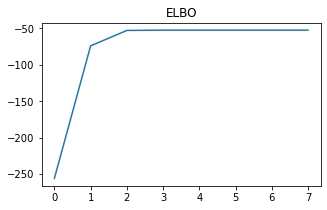

In [6]:
fig = plt.figure(figsize=(5,3))
plt.plot(llhs)
plt.title('ELBO')
plt.show()

In [7]:
alpha, beta

(0.8658916531349286, -0.11029546319607683)

#### $\beta$ =  -0.11029546319607683.
#### Hypothesis Testing

We can use LRT to perform statistical test:
$$
H_0: \beta = 0 \quad v.s.\quad H_1: \beta \neq 0
$$

Test statistic 
$$
T = 2(L(\beta = -0.11029546319607683) - 2L (\beta = 0))
$$

In [8]:
T = 2 * (model.llh(alpha, beta) - model.llh(alpha, 0.0))

In [9]:
from scipy import stats
print(f'p-value {1 - stats.chi2.cdf(T, 1)}')

p-value 0.01206204661068444


Yes, it will give inflated type I errors.

In [10]:
from numpy.random import default_rng
rng = default_rng()
class SimGen:
    def __init__(self, q, M, alpha, beta, vy, vx):
        self.q = q 
        gamma = np.zeros(M)
        for j in range(M):
            if rng.uniform() > q:
                gamma[j] = rng.normal(0, alpha**(-2))
        self.gamma_hat = rng.multivariate_normal(gamma, np.diag(vx))
        self.Gamma_hat = rng.multivariate_normal(beta*gamma, np.diag(vy))

In [11]:
M = 46
nrep = 100
ppvalues = []
for n in range(nrep):
    pvalues = []
    for q in np.linspace(0.1, 0.8, 20):
        data = SimGen(q, M, alpha, beta, vy, vx)
        model = CausalInference(data.Gamma_hat, data.gamma_hat, vy, vx)
        a, b, _ = model.solve(0.1, 0.1)
        T = 2 * (model.llh(a, b) - model.llh(a, 0))
        pvalues.append(1 - stats.chi2.cdf(T, 1))
    ppvalues.append(pvalues)
print(' ')

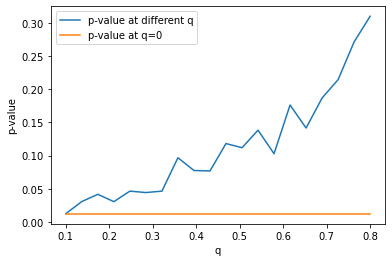

In [12]:
ppvalues = np.array(ppvalues)
pvalues = ppvalues.mean(axis=0)
plt.plot(np.linspace(0.1, 0.8, 20), pvalues, label='p-value at different q')
plt.plot(np.linspace(0.1, 0.8, 20), [0.01206204661068444]*20, label='p-value at q=0')
plt.xlabel('q')
plt.ylabel('p-value')
plt.legend()
plt.show()

As we can see, in the simulation, adding $q$ indeed inflates the type I errors.